In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L1VzZXJzL211bGxpbnNqL0Ryb3Bib3gvVGVhY2hpbmcvRUNPTjQ1MzgvbGVjdHVyZXM="
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


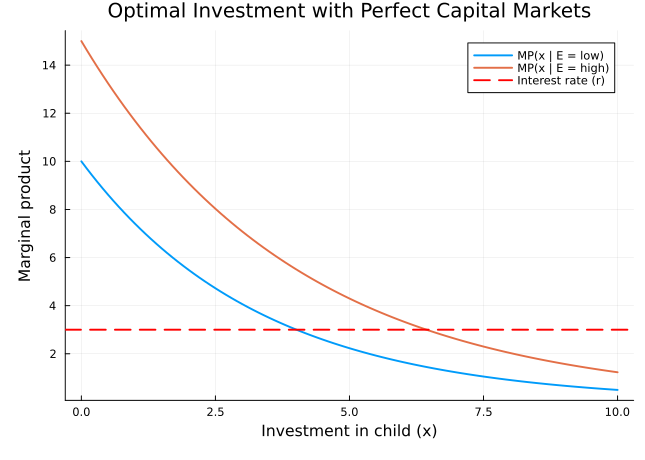

In [2]:
#| echo: false
#| output: true

using Plots

# Marginal product curves for different endowments
x = 0:0.1:10
mp_low(x) = 10 * exp(-0.3 * x)     # Low endowment
mp_high(x) = 15 * exp(-0.25 * x)   # High endowment

r = 3.0  # Interest rate

plot(x, mp_low.(x),
     label="MP(x | E = low)",
     xlabel="Investment in child (x)",
     ylabel="Marginal product",
     title="Optimal Investment with Perfect Capital Markets",
     linewidth=2,
     legend=:topright,
     grid=true,
     left_margin=5Plots.mm,
     bottom_margin=5Plots.mm)
plot!(x, mp_high.(x), label="MP(x | E = high)", linewidth=2)
hline!([r], label="Interest rate (r)", linestyle=:dash, linewidth=2, color=:red)

In [3]:
#| echo: false
#| output: true

using Plots

x = 0:0.1:10
mp(x) = 12 * exp(-0.3 * x)

# Supply curves for different income levels
r = 3.0
mc_poor(x) = 3 + 0.8 * x      # Steep: high shadow cost of funds
mc_middle(x) = 3 + 0.3 * x    # Moderate
mc_rich(x) = fill(r, length(x))  # Flat at r

plot(x, mp.(x),
     label="Marginal product",
     xlabel="Investment in child (x)",
     ylabel="Marginal return / cost",
     title="Investment Under Capital Constraints",
     linewidth=2.5,
     legend=:right,
     grid=true,
     left_margin=5Plots.mm,
     bottom_margin=5Plots.mm,
     ylim=(0, 15))
plot!(x, mc_poor.(x), label="MC (poor family)", linewidth=2, linestyle=:dash)
plot!(x, mc_middle.(x), label="MC (middle family)", linewidth=2, linestyle=:dash)
plot!(x, mc_rich.(x), label="MC (rich family)", linewidth=2, linestyle=:dash)

# Mark equilibria
x_poor = 3.5
x_middle = 6.0
x_rich = 8.5
scatter!([x_poor], [mp(x_poor)], label="", markersize=6, color=:blue)
scatter!([x_middle], [mp(x_middle)], label="", markersize=6, color=:orange)
scatter!([x_rich], [mp(x_rich)], label="", markersize=6, color=:green)

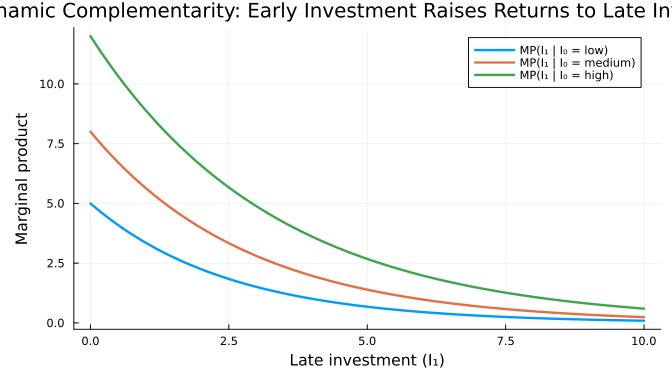

In [4]:
#| echo: false
#| output: true

using Plots

# Marginal product of late investment for different early investment levels
I1 = 0:0.1:10

# Returns to late investment depend on early investment
mp_low_I0(I1) = 5 * exp(-0.4 * I1)      # Low early investment
mp_medium_I0(I1) = 8 * exp(-0.35 * I1)  # Medium early investment
mp_high_I0(I1) = 12 * exp(-0.3 * I1)    # High early investment

plot(I1, mp_low_I0.(I1),
     label="MP(I₁ | I₀ = low)",
     xlabel="Late investment (I₁)",
     ylabel="Marginal product",
     title="Dynamic Complementarity: Early Investment Raises Returns to Late Investment",
     linewidth=2.5,
     legend=:topright,
     grid=true,
     left_margin=5Plots.mm,
     bottom_margin=5Plots.mm,
     size=(700, 400))
plot!(I1, mp_medium_I0.(I1), label="MP(I₁ | I₀ = medium)", linewidth=2.5)
plot!(I1, mp_high_I0.(I1), label="MP(I₁ | I₀ = high)", linewidth=2.5)